# Improving the Zestimate

## Project Planning

### Goals

Your customer is the zillow data science team. state your goals as if you were delivering this to zillow. They have asked for something from you and you are basically communicating in a more concise way, and very clearly, the goals as you understand them and as you have taken and acted upon through your research.

### Deliverables
1. A report (in the form of a presentation, both verbal and through a slides) that summarizes your findings about the drivers of the Zestimate error. This will come from the analysis you do during the exploration phase of the pipeline. In the report, you will have charts that visually tell the story of what is driving the errors.

2. A Jupyter notebook that contains a clearly labeled section and code clearly documented for each the stages below (project planning, data acquisition, data prep, exploration, and modeling). All of the work will take place in your jupyter notebook.

### Data Dictionary & Details

- bathroomcnt: Number of bathrooms in home including fractional bathrooms
- bedroomcnt: Number of bedrooms in home
- calculatedfinishedsquarefeet: Calculated total finished living area of the home
- fullbathcnt: Number of full bathrooms (sink, shower + bathtub, and toilet) present in home
- garagecarcnt: Total number of garages on the lot including an attached garage
- roomcnt: Total number of rooms in the principal residence
- yearbuilt: The Year the principal residence was built
- taxvaluedollarcnt: The total tax assessed value of the parcel
- taxamount: The total property tax assessed for that assessment year
- parcelid: Unique identifier for parcels (lots)

### Prepare your environment

Imported libraries I will use throughout the project

In [101]:
# Python 3 environment libraries

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')

# Modeling
import statsmodels.api as sm

from scipy.stats import pearsonr
from scipy.stats import iqr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

### Data Acquisition

Acquire via a .csv file

In [121]:
path = './'

### Loading Dataset using 'properties_2016.csv'
dfproperties_2016 = pd.read_csv(path + 'properties_2016.csv')

### Loading Dataset using 'train_2016.csv'
dftrain_2016 = pd.read_csv(path + 'train_2016.csv')

In [122]:
### Loading Dataset using 'train_2016.csv'
dftrain_2016 = pd.read_csv(path + 'train_2016.csv')

In [123]:
### Creating data frame a
df_a = pd.DataFrame(dfproperties_2016, columns = [
        'bathroomcnt',
        'bedroomcnt',
        'calculatedfinishedsquarefeet',
        'fullbathcnt',
        'garagecarcnt',
        'roomcnt',
        'yearbuilt',
        'taxvaluedollarcnt',
        'taxamount',
        'parcelid'])

In [124]:
### Creating data frame b
df_b = pd.DataFrame(dftrain_2016, columns = ['parcelid', 'logerror'])

In [125]:
### Joining the both a and b along the 'parcelid' value
df_join = pd.merge(df_a, df_b, how='inner', on='parcelid')

### Sumarize Data

In [126]:
### Creating a summary with print statements
def summarize_df(df):
    print("\nRows & Columns:\n")
    print(df.shape)
    print("\nColumn Info:\n")
    print(df.info())
    print("\nFirst 5 rows:\n")
    print(df.head())
    print("\nLast 5 rows:\n")
    print(df.tail())
    print("\nMissing Values:\n")
    missing_vals = df.columns[df.isnull().any()]
    print(df.isnull().sum())
    print("\nSummary Stats:\n")
    print(df.describe())
    print("\nColumn IQR:\n")
    var_names = df.columns.values
    for var in var_names:
        print(var+":")
        print(iqr(df[var],axis=0))

In [127]:
summarize_df(df_join)


Rows & Columns:

(90275, 11)

Column Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 11 columns):
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
calculatedfinishedsquarefeet    89614 non-null float64
fullbathcnt                     89093 non-null float64
garagecarcnt                    29937 non-null float64
roomcnt                         90275 non-null float64
yearbuilt                       89519 non-null float64
taxvaluedollarcnt               90274 non-null float64
taxamount                       90269 non-null float64
parcelid                        90275 non-null int64
logerror                        90275 non-null float64
dtypes: float64(10), int64(1)
memory usage: 8.3 MB
None

First 5 rows:

   bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  fullbathcnt  \
0          2.5         3.0                        1264.0          2.0   
1          1.0         2.

### Initial Thoughts, Ideas, Hypotheses

- First thing: find all the NaN values and figure out what to do with them
- Replace all the NaN values with the mean to see if that changes the correlation with the logerror

### Features
- features with too many NaN values to deal with I want to remove them from the model
- remove **fullbathcnt**, **garagecnt** and **roomcnt**

### Normalization
- figure out how to normalize the data and see if that makes a difference in the model

### Outliers
- I think the outliers in this data set have such a small amount of impace to the overall logerror because there aren't too many of them to make a big impact
- remove lots without a structure

### Goal
- Goal is to see what features have the strongest corelation and remove one of them; the one that has the weakest correlation to the logerror

### Data Preparation

Goal: leave this section with a dataset that is ready to be analyzed.

In [128]:
### Create a variable, colnames, that is a list of the column names.
variables = pd.DataFrame(df_join.columns, columns=['colnames'])

In [129]:
### Replace Null Values
def replace_null_data(df, column_name, numerical = True):
    if numerical == True:
        df[column_name] = df[column_name].fillna(df[column_name].mean())
    else:
        df[column_name] = df[column_name].fillna(df[column_name].mode()[0])
    
    return df

In [130]:
df_join = replace_null_data(df_join,'calculatedfinishedsquarefeet')
df_join = replace_null_data(df_join,'taxamount')
df_join = replace_null_data(df_join,'taxvaluedollarcnt')
df_join = replace_null_data(df_join,'yearbuilt')
df_join = replace_null_data(df_join,'logerror')

In [131]:
### Drop unnecessary columns
columns_to_remove = ['fullbathcnt',
                     'garagecarcnt',
                     'roomcnt',
                     'parcelid']
df_fixed = df_join.drop(columns_to_remove, axis=1)

### Create a list of the independent variable name
df_fixed.columns.values

array(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'yearbuilt', 'taxvaluedollarcnt', 'taxamount', 'logerror'],
      dtype=object)

In [144]:
### Remove all outliers past the 3rd standard dev
df_fixed = df_fixed[(np.abs(stats.zscore(df_fixed)) < 3).all(axis=1)]

In [145]:
df_fixed.sort_values(['logerror'], ascending=True).sample(10)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,yearbuilt,taxvaluedollarcnt,taxamount,logerror
9908,1.5,2.0,1108.0,1973.0,365000.0,4250.44,-0.0141
6250,2.0,4.0,1430.0,1964.0,381276.0,4090.78,-0.0101
30118,2.5,3.0,1644.0,1990.0,371420.0,4768.22,0.0010
15011,1.0,3.0,1598.0,1951.0,804727.0,9935.83,-0.1256
83200,3.0,4.0,1464.0,1923.0,240782.0,3107.76,0.1169
77738,1.0,2.0,810.0,1950.0,145582.0,2030.21,-0.0131
58957,1.0,1.0,783.0,1976.0,228313.0,2801.05,0.0178
32419,1.0,2.0,1290.0,1942.0,60324.0,789.07,0.0402
46837,2.5,3.0,1311.0,1982.0,285492.0,3628.28,-0.0090
16446,3.0,4.0,2139.0,1985.0,643461.0,7651.92,0.0169


In [146]:
### Create a list of the independent variable names (aka attributes) and assign it to x_vars
x_vars = df_fixed.columns.values
x_vars

array(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'yearbuilt', 'taxvaluedollarcnt', 'taxamount', 'logerror'],
      dtype=object)

In [147]:
### Clearly identify your dependent (target) variable
y = df_fixed.columns.values[5]

In [148]:
### Create a list of the independent variable names (aka attributes) and assign it to x_vars
x_vars = df_fixed.columns.values

In [149]:
### Clearly identify your dependent (target) variable
y = df_fixed.columns.values[3]

In [150]:
summarize_df(df_fixed)


Rows & Columns:

(80576, 7)

Column Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80576 entries, 0 to 90274
Data columns (total 7 columns):
bathroomcnt                     80576 non-null float64
bedroomcnt                      80576 non-null float64
calculatedfinishedsquarefeet    80576 non-null float64
yearbuilt                       80576 non-null float64
taxvaluedollarcnt               80576 non-null float64
taxamount                       80576 non-null float64
logerror                        80576 non-null float64
dtypes: float64(7)
memory usage: 4.9 MB
None

First 5 rows:

   bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  yearbuilt  \
0          2.5         3.0                        1264.0     1986.0   
1          1.0         2.0                         777.0     1990.0   
2          2.0         3.0                        1101.0     1956.0   
3          1.5         2.0                        1554.0     1965.0   
4          2.5         4.0                     

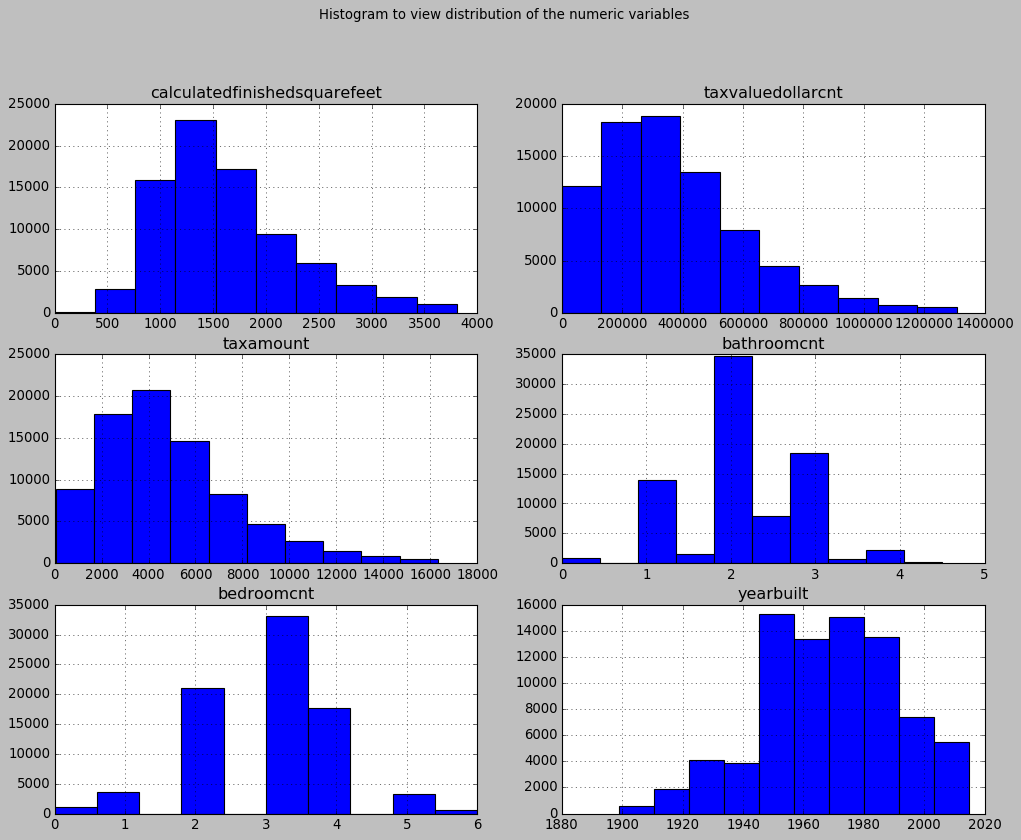

In [151]:
### View the distribution of the numeric variables with histograms
plt.figure(figsize=(15,15))
plt.suptitle('Histogram to view distribution of the numeric variables')

for i, col in enumerate(['calculatedfinishedsquarefeet', 
                         'taxvaluedollarcnt',
                         'taxamount',
                         'bathroomcnt',
                         'bedroomcnt',
                         'yearbuilt']):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df_fixed[col]  
    plt.subplot(4, 2, plot_number)
    plt.title(col)
    series.hist(bins=10, density=False, cumulative=False, log=False)

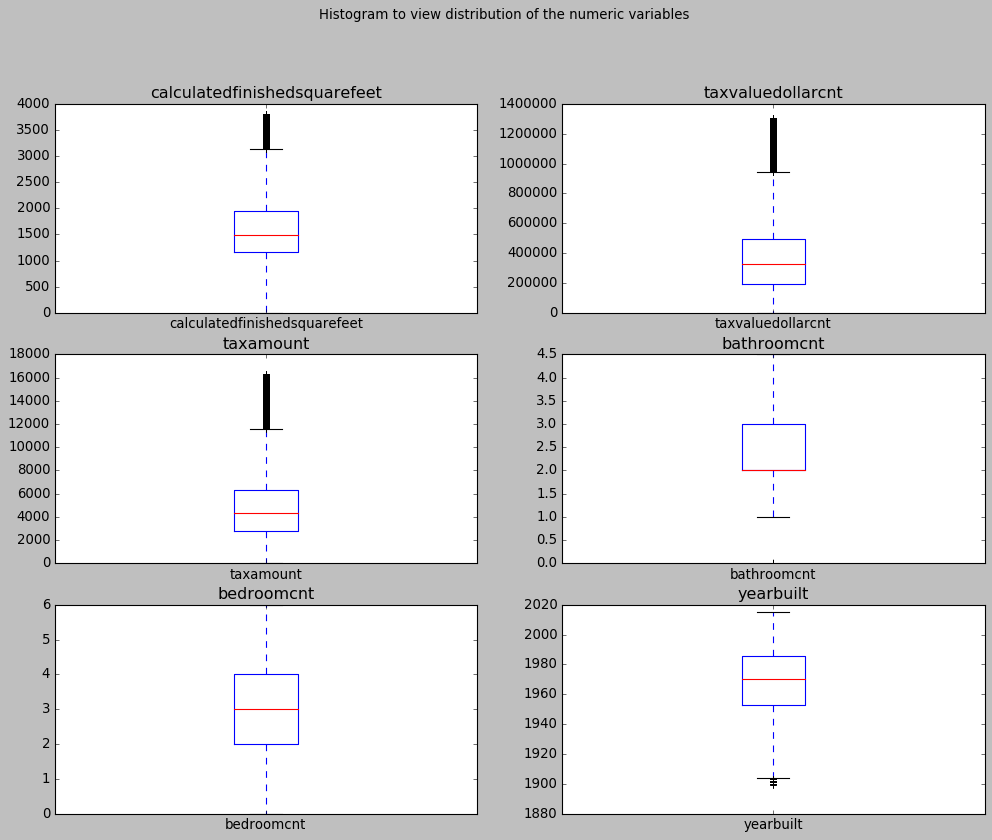

In [152]:
### View the distribution of the numeric variables with boxplots to visually see the outliers
plt.figure(figsize=(15,15))
plt.suptitle('Histogram to view distribution of the numeric variables')

for i, col in enumerate(['calculatedfinishedsquarefeet', 
                         'taxvaluedollarcnt',
                         'taxamount',
                         'bathroomcnt',
                         'bedroomcnt',
                         'yearbuilt']):  
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df_fixed[col]  
    plt.subplot(4, 2, plot_number)
    plt.title(col)
    series.plot.box()

### Data Exploration

Goal is to address each of the questions you posed in your planning & brainstorming through visual or statistical analysis.

In [153]:
### Split data into training and test datasets
X = df_fixed.drop(['logerror'], axis=1)
y = df_fixed[['logerror']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) 

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [141]:
train = pd.concat([X_train, y_train], axis=1)
print("Train columns:  %s" % list(train.columns))
print("Train dimensions (rows, columns):", train.shape)

Train columns:  ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'taxvaluedollarcnt', 'taxamount', 'logerror']
Train dimensions (rows, columns): (68810, 7)


In [142]:
print("Test columns:  %s" % list(test.columns))
print("Test dimensions (rows, columns):", test.shape)

Test columns:  ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'taxvaluedollarcnt', 'taxamount', 'logerror']
Test dimensions (rows, columns): (17203, 7)


<Figure size 800x640 with 0 Axes>

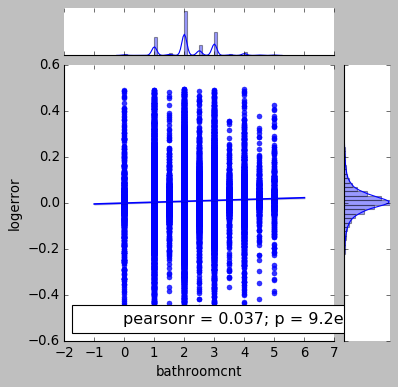

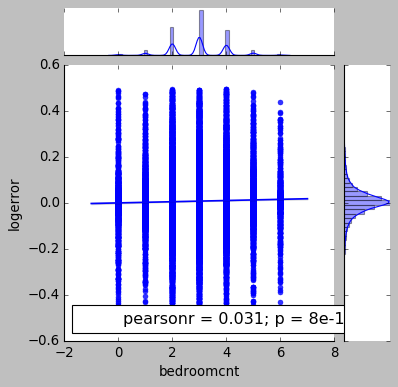

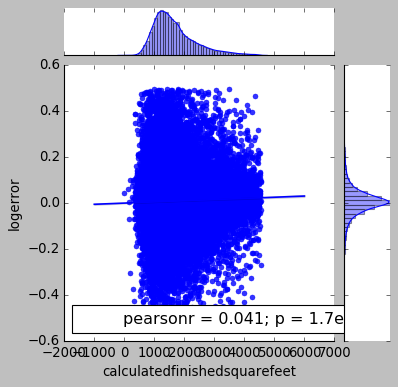

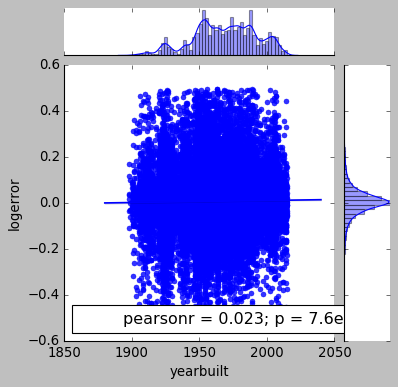

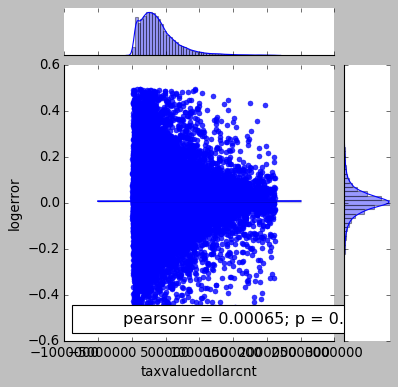

In [143]:
### Create a jointplot for each independent variable with the dependent variable.
plt.figure(figsize=(10, 8))

for i in range(0,5):
    j = sns.jointplot(x_vars[i], 'logerror', data=train, kind='reg', height=5);
    j.annotate(stats.pearsonr)

In [26]:
if X_train.shape[0] == y_train.shape[0]:
    print("X & y train rows ARE equal")
else:
    print("X & y train rows ARE NOT equal")


if X_test.shape[0] == y_test.shape[0]:
    print("X & y test rows ARE equal")
else:
    print("X & y test rows ARE NOT equal")

if train.shape[1] == test.shape[1]:
    print("Number of columns in train & test ARE equal")
else:
    print("Number of columns in train & test ARE NOT equal")
 
train_split = train.shape[0] / (train.shape[0] + test.shape[0])
test_split = test.shape[0] / (train.shape[0] + test.shape[0])

print("Train Split: %.2f" % train_split)
print("Test Split: %.2f" % test_split)

X & y train rows ARE equal
X & y test rows ARE equal
Number of columns in train & test ARE equal
Train Split: 0.80
Test Split: 0.20


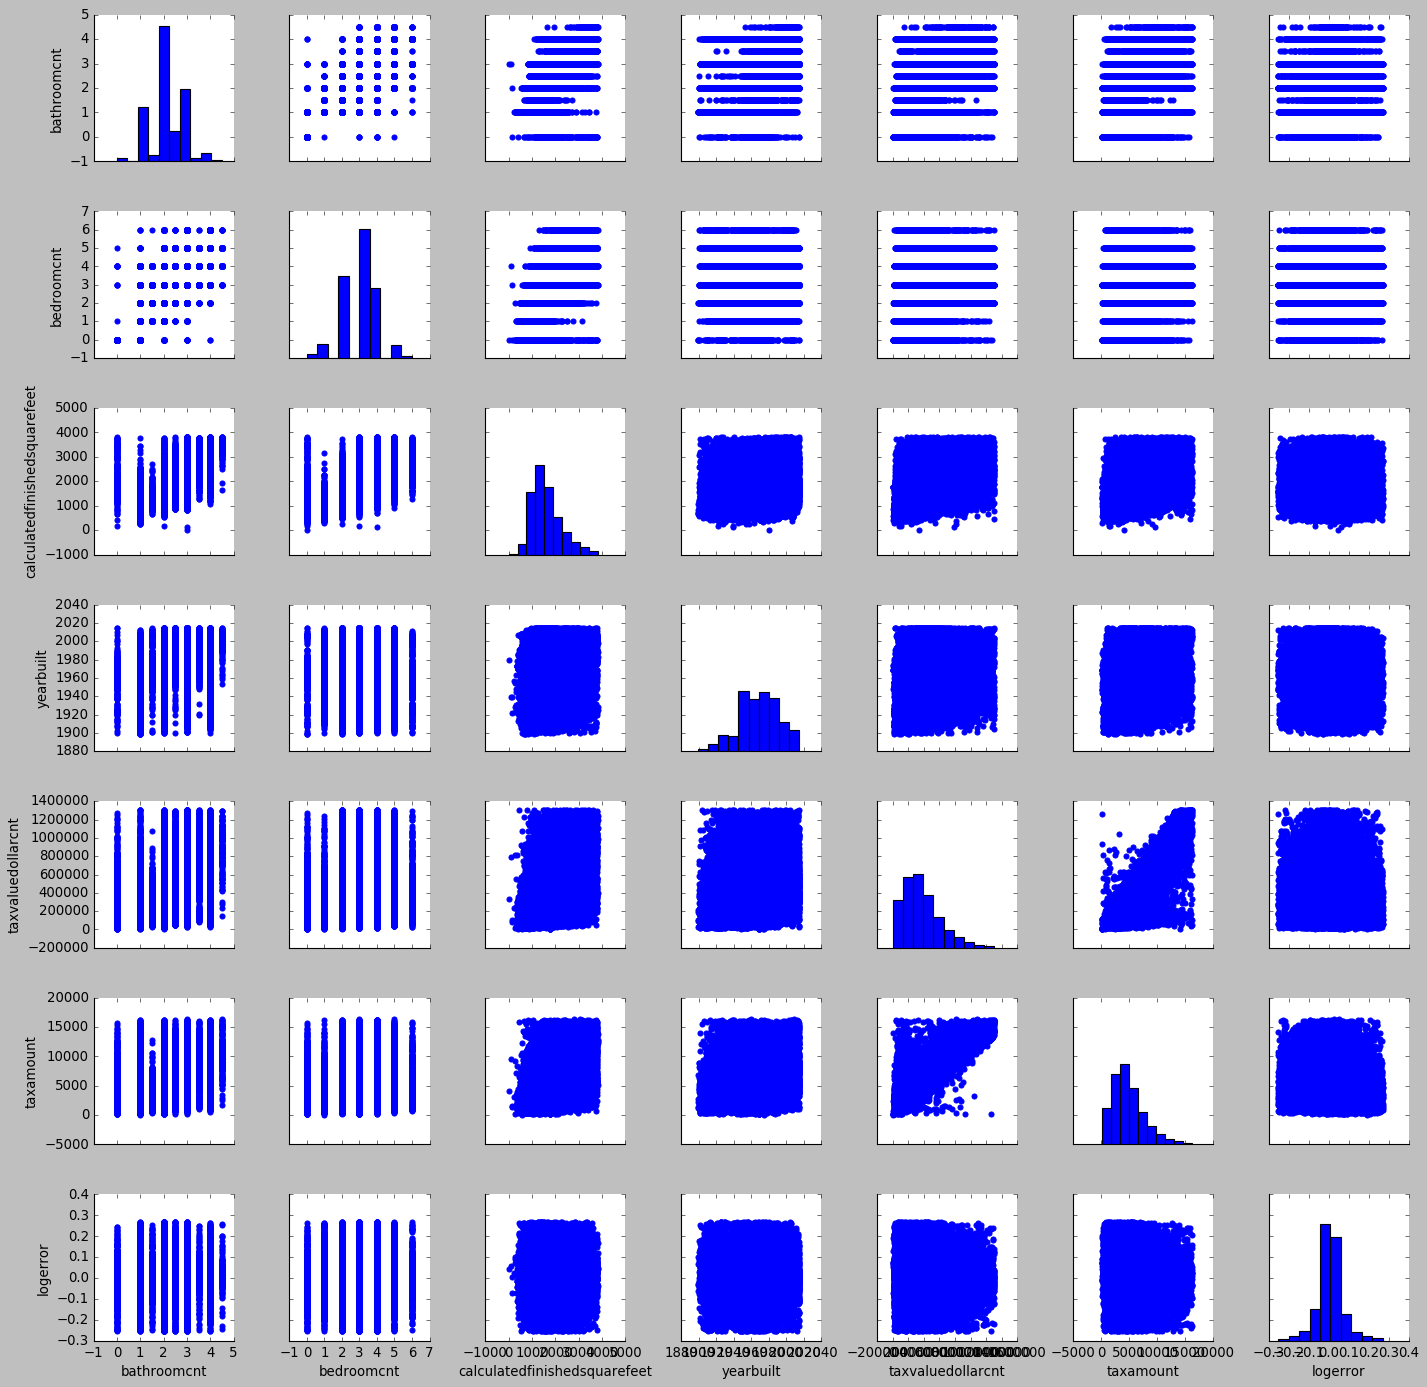

In [154]:
### Create a feature plot using seaborn's PairGrid() of the interaction between each variable (dependent + independent).
g = sns.PairGrid(train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text xticklabel objects>)

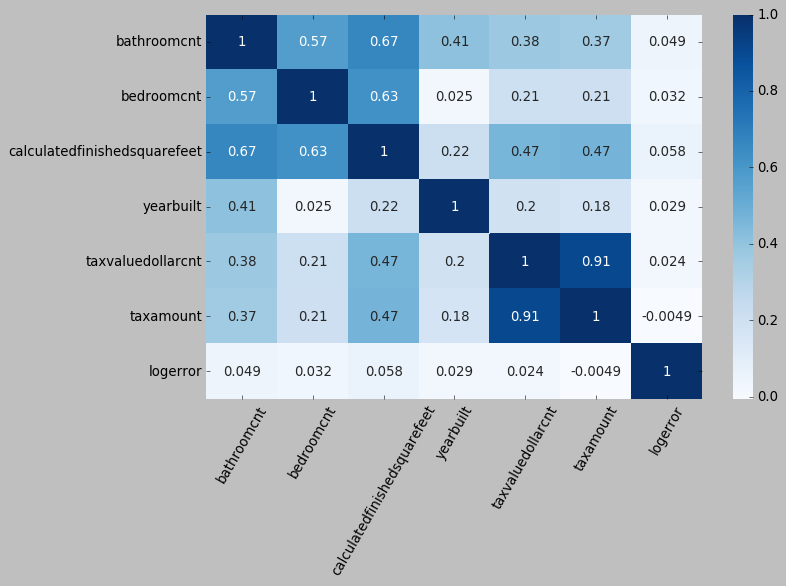

In [155]:
### Create a heatmap of the correlation between each variable pair.
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(), cmap='Blues', annot=True)
plt.xticks(rotation=60)

In [156]:
### Is the logerror significantly different for homes with 3 bedrooms vs those with 5 or more bedrooms?
three_br = train[train.bedroomcnt == 3]
five_br = train[train.bedroomcnt >= 3]

from scipy.stats import ttest_ind
ttest_ind(three_br.logerror, five_br.logerror)

Ttest_indResult(statistic=-2.924886384118291, pvalue=0.003446921163004604)

In [157]:
### Do the same for another 2 samples you are interested in comparing (e.g. those with 1 bath vs. x baths)
one_ba = train[train.bathroomcnt <= 2]
four_ba = train[train.bathroomcnt >= 3]

from scipy.stats import ttest_ind
ttest_ind(one_ba.logerror, four_ba.logerror)

Ttest_indResult(statistic=-11.038796883749823, pvalue=2.6495187972925932e-28)

### Findings

***Strong Correlations***
- 'taxvaluedollarcnt' and 'taxamount' have the strongest correlation so I will remove taxamount when I process my linear modeling
- 'calculatedfinishedsquarefeet' and 'bathroomcnt' have the second strongest correlation so I will remove bathroom count when I process my linear model
- **Yearbuilt** looks like the most interesting feature bumped up with logerror

### Data Modeling

In [158]:
### Create a dictionary that describe the r and p values
column_names = X_train.columns
r_and_p_values = [pearsonr(X_train[col], y_train.logerror) for col in column_names]

logerror_corr_dict = dict(zip(column_names, r_and_p_values))
logerror_corr_dict

{'bathroomcnt': (0.049187670889082165, 7.893234967879365e-36),
 'bedroomcnt': (0.03217658354809259, 3.0518097008300003e-16),
 'calculatedfinishedsquarefeet': (0.058439491371996485, 6.999470584848582e-50),
 'yearbuilt': (0.029323717718089417, 9.588690973362595e-14),
 'taxvaluedollarcnt': (0.024073464369864864, 9.791468439108577e-10),
 'taxamount': (-0.004853285394152716, 0.21788083407335676)}

In [159]:
### Normalize Data of selected cells
def norm_df_column(df, column_name):
    df[column_name] = (df[column_name] - df[column_name].mean())/df[column_name].std()
    return df

In [160]:
# X_train = norm_df_column(X_train, 'price_per_sqf')
# X_test = norm_df_column(X_train, 'price_per_sqf') 

In [161]:
# X_train['price_per_sqf'] = (X_train.taxvaluedollarcnt / X_train.calculatedfinishedsquarefeet)
# X_test['price_per_sqf'] = (X_test.taxvaluedollarcnt / X_test.calculatedfinishedsquarefeet)


In [162]:
X_train = norm_df_column(X_train, 'calculatedfinishedsquarefeet')
X_train = norm_df_column(X_train, 'taxvaluedollarcnt')
X_train = norm_df_column(X_train, 'taxamount')

X_test = norm_df_column(X_test, 'calculatedfinishedsquarefeet')
X_test = norm_df_column(X_test, 'taxvaluedollarcnt')
X_test = norm_df_column(X_test, 'taxamount')

In [163]:
### Feature selection using statsmodels.OLS (Ordinary Least Squares)
ols_model = sm.OLS(y_train, X_train)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     169.6
Date:                Tue, 26 Mar 2019   Prob (F-statistic):          6.60e-215
Time:                        10:11:26   Log-Likelihood:                 83558.
No. Observations:               64460   AIC:                        -1.671e+05
Df Residuals:                   64454   BIC:                        -1.671e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
bathroomcnt                      0.0018      0.000      3.688      0.000       0.001       0.003
bedroomcnt                      -0.0011      0.000     -3.063      0.002      -0.002      -0.000
calculatedfinishedsquarefeet     0.0045      0.000     11.085      0.000       0.004       0.005
yearbuilt                     2.435e-06   6.41e-07      3.797      0.000    1.18e-06    3.69e-06
taxvaluedollarcnt                0.0096      0.001     15.188      0.000       0.008       0.011
taxamount                       -0.0115      0.001    -18.195      0.000      -0.013      -0.010
==============================================================================
Omnibus:                     4347.682   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19260.142
Skew:                           0.174   Prob(JB):                         0.00
Kurtosis:                       5.655   Cond. No.                     6.56e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Linear Model 1

In [164]:
# Create linear regression objects
lm1 = LinearRegression()
print(lm1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [165]:
lm1.fit(X_train, y_train)
print(lm1)

lm1_y_intercept = lm1.intercept_
print(lm1_y_intercept)

lm1_coefficients = lm1.coef_
print(lm1_coefficients)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[-0.05637597]
[[ 1.31469821e-03 -8.28173046e-04  4.49812839e-03  3.12206330e-05
   9.56935411e-03 -1.14716211e-02]]


In [166]:
y_pred_lm1 = lm1.predict(X_train)

In [167]:
mse_lm1 = mean_squared_error(y_train, y_pred_lm1)
print("lm1\n  mse: {:.6}".format(mse_lm1))

lm1
  mse: 0.00438085


### Linear Model 2

In [168]:
lm2 = LinearRegression()
print(lm2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [169]:
lm2.fit(X_train.drop(['taxamount'], axis=1), y_train)
print(lm2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [170]:
lm2_y_intercept = lm2.intercept_
print(lm2_y_intercept)

lm2_coefficients = lm2.coef_
print(lm2_coefficients)

[-0.06767818]
[[ 1.37727962e-03 -6.78687545e-04  3.68133588e-03  3.66703761e-05
  -5.55123039e-04]]


In [171]:
y_pred_lm2 = lm2.predict(X_train.drop(['taxamount'],axis=1))

In [172]:
mse_lm2 = mean_squared_error(y_train, y_pred_lm2)
print("lm1\n  mse: {:.6}".format(mse_lm2))

lm1
  mse: 0.0044032


### Linear Model 3

In [173]:
lm3 = LinearRegression()
print(lm3)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [174]:
lm3.fit(X_train.drop(['taxamount','bathroomcnt'],axis=1), y_train)
print(lm3)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [175]:
lm3_y_intercept = lm3.intercept_
print(lm3_y_intercept)

lm3_coefficients = lm3.coef_
print(lm3_coefficients)

[-0.09425055]
[[-3.37808889e-04  4.06499147e-03  5.11639154e-05 -4.67674211e-04]]


In [176]:
y_pred_lm3 = lm3.predict(X_train.drop(['taxamount','bathroomcnt'],axis=1))

In [177]:
mse_lm3 = mean_squared_error(y_train, y_pred_lm3)
print("lm1\n  mse: {:.6}".format(mse_lm3))

lm1
  mse: 0.00440367


Text(0.5, 1.0, 'Predicted vs Logerror')

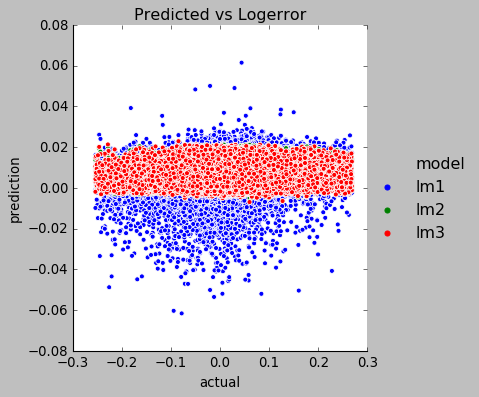

In [178]:
# the predictions are a 1 x 83 two dimensional matrix, but we want just
# a single array of predictions. We can use the .ravel method to achieve
# this.

pd.DataFrame({'actual': y_train.logerror,
              'lm1': y_pred_lm1.ravel(),
              'lm2': y_pred_lm2.ravel(),
              'lm3': y_pred_lm3.ravel()})\
    .melt(id_vars=['actual'], var_name='model', value_name='prediction')\
    .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')

plt.title('Predicted vs Logerror')

In [179]:
mean_squared_error(y_train, y_pred_lm1) < mean_squared_error(y_train, y_pred_lm2)

True

In [180]:
mean_squared_error(y_train, y_pred_lm1) < mean_squared_error(y_train, y_pred_lm3)

True

### Predict logerror using testing data

In [181]:
# Make predictions using the testing set
y_pred_lm1 = lm1.predict(X_test)

In [182]:
mse = mean_squared_error(y_test, y_pred_lm1)
print("Mean squared error: %.2f" % mse)

Mean squared error: 0.00


In [183]:
r2 = r2_score(y_test, y_pred_lm1)
print('{:.2%} of the variance in the zestyimates logerror can be explained by calculatedfinishedsquarefeet.'
      .format(r2))

0.86% of the variance in the zestyimates logerror can be explained by calculatedfinishedsquarefeet.


Text(0, 0.5, 'Residuals')

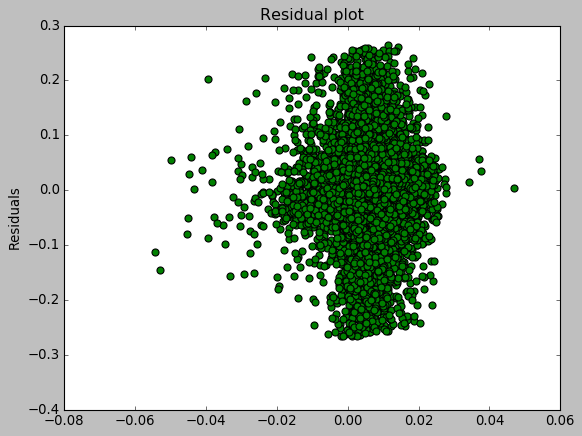

In [185]:
plt.scatter(y_pred_lm1, y_pred_lm1 - y_test, c='g', s=40)
# plt.hlines(y=0, xmin=-.0001, xmax=.0001)
plt.title("Residual plot")
plt.ylabel('Residuals')

### Summary

- Need more practice with different types of regression models
- Learn when to normalize vs standardize
- Learn how to bin and when to bin
- LEARN TO STOP LOOKING IF NOTHING IS THERE